## Objective of the notebook:

In this notebook, we explore the given customer order dataset and make some analysis and inferences. Based on this data analysis and recency-frequency segmentation, we could build rule-based marketing/growth strategies to prevent churn cases on time. 

## Data dictionary  
  
There are two data samples provided as (gunzipped) CSV files.  
  
### Order data  
  
The order dataset contains the history of orders placed by customers acquired between 2015-03-01 and 2017-02-28. The data points were *synthetically* generated to reflect patterns of real data for the purpose of the exercise.  
  
The dataset columns definition:  

  
|Column|Description|  
|---|---|  
|*customer_id*|Unique customer ID.|  
|*order_date*|Local date of the order.|  
|*order_hour*|Local hour of the order.|  
|*customer_order_rank*|Number of a successful order counted in chronological order starting with 1 (an empty value would correspond to a failed order).|  
|*is_failed*|0 if the order succeeded.<br>1 if the order failed.|  
|*voucher_amount*|The discounted amount if a voucher (discount) was used at order's checkout.|  
|*delivery_fee*|Fee charged for the delivery of the order (if applicable).|  
|*amount_paid*|Total amount paid by the customer (the *voucher_amount* is already deducted and the *delivery_fee* is already added).|  
|*restaurant_id*|Unique restaurant ID.|  
|*city_id*|Unique city ID.|  
|*payment_id*|Identifies the payment method the customer has chosen (such as cash, credit card, PayPal, ...).|  
|*platform_id*|Identifies the platform the customer used to place the order (web, mobile app, mobile web, …).|  
|*transmission_id*|Identifies the method used to place the order to the restaurant (fax, email, phone, and different kinds of proprietary devices or point-of-sale systems).|  
  
The data rows are ordered by *customer_id* and *order_date*: all orders of one customer appear in chronological order on consecutive rows.  

### Labeled data  
  
The [labeled dataset](./data/machine_learning_challenge_labeled_data.csv.gz) flags whether the customers placed at least one order within 6 months after 2017-02-28 or not.  
  
The dataset columns definition:  
|Column|Description|  
|---|---|  
|*customer_id*|Unique customer ID.|  
|*is_returning_customer*|0 if the customer did not return (did not order again) in the 6 months after 2017-02-28.<br>1 if the customer returned (ordered again) at least once after 2017-02-28.|  
  
The data rows are ordered by *customer_id*.  

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings("ignore") 
plt.style.use('bmh')

break_point = datetime(2017, 2, 28)

### Importing datasets

In [2]:
def read_data():
    print('Reading files...')    
    order_df = pd.read_csv('../input/machine_learning_challenge_order_data.csv')
    print('Order data has {} rows and {} columns'.format(order_df.shape[0], order_df.shape[1]))
    label_df = pd.read_csv('../input/machine_learning_challenge_labeled_data.csv')
    print('Label data has {} rows and {} columns'.format(label_df.shape[0], label_df.shape[1]))
    df = order_df.merge(label_df, on='customer_id')
    return df

df = read_data()

Reading files...
Order data has 786600 rows and 13 columns
Label data has 245455 rows and 2 columns


### Profile Report

In [3]:
profile = ProfileReport(df)
profile.to_file(output_file='output.html')
profile.to_widgets()

#### Warnings by pandas-profiling
- Dataset has 546 (0.1%) duplicate rows
- customer_id has a high cardinality: 245455 distinct values
- order_date has a high cardinality: 776 distinct values
- customer_order_rank has 24767 (3.1%) missing values
- voucher_amount is highly skewed (γ1 = 30.39394065)
- platform_id is highly skewed (γ1 = -22.53663783)
- voucher_amount has 743462 (94.5%) zeros
- delivery_fee has 597536 (76.0%) zeros

### Descriptive Analysis

In [4]:
df.describe()

,order_hour,customer_order_rank,is_failed,voucher_amount,delivery_fee,amount_paid,restaurant_id,city_id,payment_id,platform_id,transmission_id,is_returning_customer
count,786600.000000,761833.000000,786600.000000,786600.000000,786600.00000,786600.000000,7.866000e+05,786600.000000,786600.000000,786600.000000,786600.000000,786600.000000
mean,17.588796,9.436810,0.031486,0.091489,0.18118,10.183271,1.628641e+08,47179.750497,1668.509077,29868.529382,4253.246112,0.519818
std,3.357192,17.772322,0.174628,0.479558,0.36971,5.618121,8.783082e+07,25904.630565,87.192665,1160.893265,572.855666,0.499607
min,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,7.349800e+04,230.000000,1491.000000,525.000000,212.000000,0.000000
25%,16.000000,1.000000,0.000000,0.000000,0.00000,6.648120,8.602350e+07,24799.000000,1619.000000,29463.000000,4228.000000,0.000000
50%,18.000000,3.000000,0.000000,0.000000,0.00000,9.027000,1.696135e+08,46467.000000,1619.000000,29815.000000,4324.000000,1.000000
75%,20.000000,10.000000,0.000000,0.000000,0.00000,12.213000,2.284335e+08,67886.000000,1779.000000,30231.000000,4356.000000,1.000000
max,23.000000,369.000000,1.000000,93.398900,9.86000,1131.030000,3.404535e+08,100205.000000,1811.000000,30423.000000,21124.000000,1.000000


In [5]:
pd.concat([df.count(), df.nunique(), df.isnull().sum(), round(100 * df.isnull().sum()/len(df), 2)],
              axis=1).rename(columns={0:'Count', 1:'Unique Value', 2:'Missing Value', 3:'Missing (%)'})

,Count,Unique Value,Missing Value,Missing (%)
customer_id,786600,245455,0,0.00
order_date,786600,776,0,0.00
order_hour,786600,24,0,0.00
customer_order_rank,761833,369,24767,3.15
is_failed,786600,2,0,0.00
voucher_amount,786600,911,0,0.00
delivery_fee,786600,98,0,0.00
amount_paid,786600,6471,0,0.00
restaurant_id,786600,13569,0,0.00
city_id,786600,3749,0,0.00


786600 orders from 245455 customers (31.2%)

24767 missing values in customer_order_rank (3.1%)

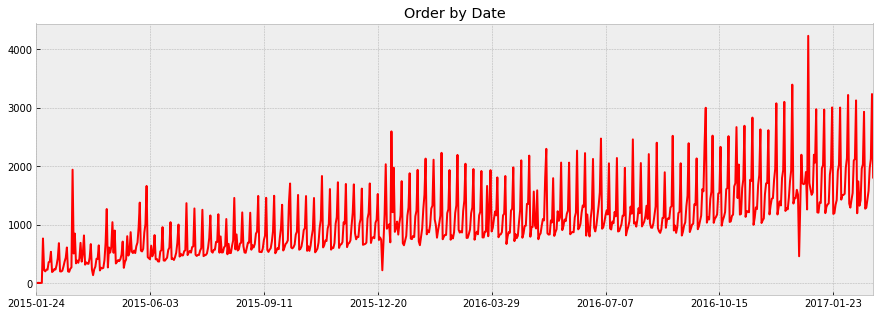

In [6]:
df['demand'] = 1
df[df.order_date>'2015-01'].groupby('order_date')['demand'].sum().plot(color='red', figsize=(15, 5),
                                    title='Order by Date')
plt.xlabel('')
plt.show()

In [7]:
df['order_date']=pd.to_datetime(df['order_date'])
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month
df['week'] = df['order_date'].dt.week
df['day'] = df['order_date'].dt.day
df['dayofweek'] = df['order_date'].dt.dayofweek
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(np.int8)

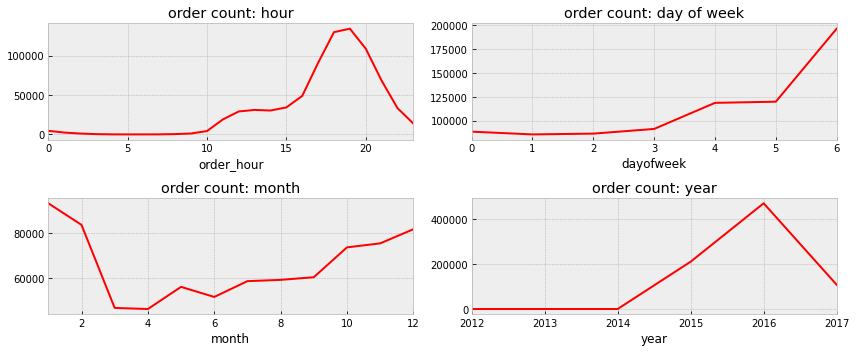

In [8]:
fig, [[ax0, ax1], [ax2, ax3]] = plt.subplots(2,2, figsize=(18, 5))

df.groupby('order_hour')['demand'].sum().plot(color='red', figsize=(12, 5), 
                                    title='order count: hour',ax=ax0)

df.groupby('dayofweek')['demand'].sum().plot(color='red', figsize=(12, 5),
                                    title='order count: day of week',ax=ax1)

df.groupby('month')['demand'].sum().plot(color='red', figsize=(12, 5),
                                    title='order count: month',ax=ax2)

df.groupby('year')['demand'].sum().plot(color='red', figsize=(12, 5),
                                    title='order count: year',ax=ax3)
plt.tight_layout()
plt.show()

### Revenue Distribution

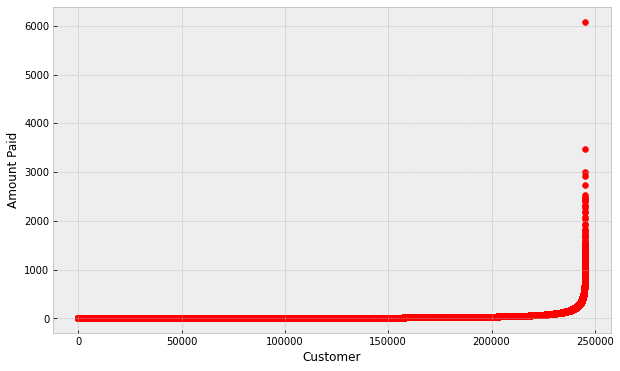

In [9]:
gdf = df.groupby("customer_id")["amount_paid"].sum().reset_index()

plt.figure(figsize=(10,6))
plt.scatter(range(gdf.shape[0]), np.sort(gdf["amount_paid"].values), color='red')
plt.xlabel('Customer', fontsize=12)
plt.ylabel('Amount Paid', fontsize=12)
plt.show()

The 80/20 rule is still valid. Generally, loyal customers create most of the revenue.

### Target Variable

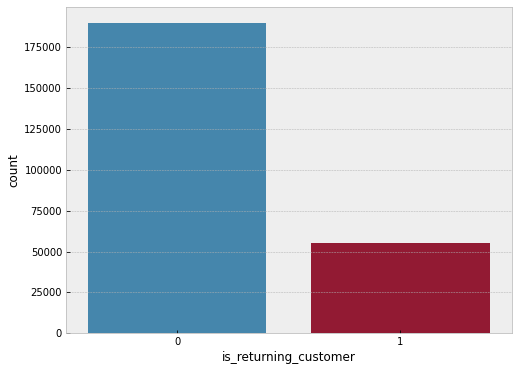

In [10]:
plt.figure(figsize = (8,6))
grouped_df = df.groupby('customer_id').last()
ax = sns.countplot(x="is_returning_customer", data=grouped_df)

### Order vs Recency Matrix

Two main features characterize the behaviors of eCommerce users: the number of orders and recency, so we analyze our customers in order-recency matrix before the modeling part. 

Almost 40% of customers (left below) are in the 1st order and don't order in the last 24 weeks. We could label them as promo-seeker or churn without needing an ml model. 

We create an average returning matrix that helps us to predict churn cases easily. As we see in the last notebook, predictions of ML are very similar to the below. 

In [11]:
order_bins = [0, 1, 4, 9, 49, 99, 999]
order_labels = ["1", "2-4", "5-9", "10-49", "50-99", "100+"]

grouped_df['order_date'] = pd.to_datetime(grouped_df['order_date']) 
grouped_df['recency'] = (break_point - grouped_df['order_date']) / np.timedelta64(1, 'D')
grouped_df['order_binned'] = pd.cut(grouped_df['customer_order_rank'], bins=order_bins, labels=order_labels)

recency_bins = [0, 7, 14, 28, 84, 168, 1680]
recency_labels = ["0-7", "8-14", "15-28", "29-84", "85-168", "168+"]
grouped_df['recency_binned'] = pd.cut(grouped_df['recency'], bins=recency_bins, labels=recency_labels)

result_probs = grouped_df.pivot_table(columns='order_binned', 
                                     index='recency_binned', values='is_returning_customer', aggfunc='mean')
result_count = grouped_df.pivot_table(columns='order_binned', 
                                     index='recency_binned', values='is_returning_customer', aggfunc='count')

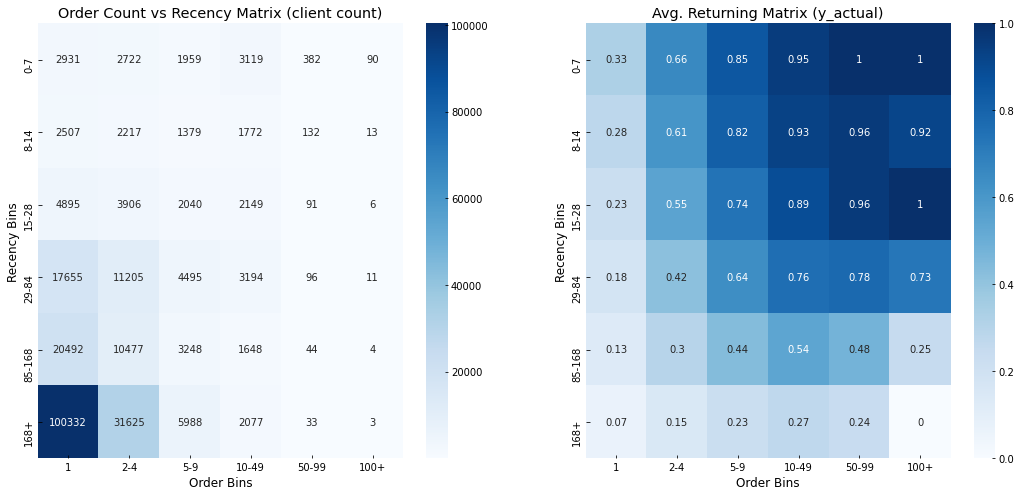

In [12]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(18, 8))

sns.heatmap(data = round(result_count, 2), annot = True, cmap='Blues', fmt='g', ax=ax0)
ax0.set_title('Order Count vs Recency Matrix (client count)')
ax0.set_xlabel('Order Bins')
ax0.set_ylabel('Recency Bins')

sns.heatmap(data = round(result_probs, 2), annot = True, cmap='Blues', fmt='g', ax=ax1)
ax1.set_title('Avg. Returning Matrix (y_actual)')
ax1.set_xlabel('Order Bins')
ax1.set_ylabel('Recency Bins')
plt.show()

### Correlation Matrix

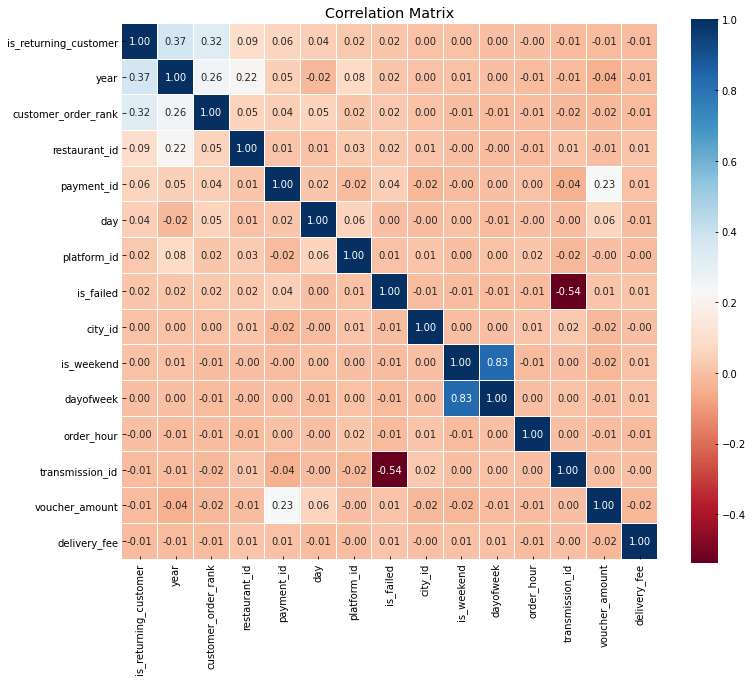

In [18]:
a,x = plt.subplots(figsize=(12,10))
corr = grouped_df.dropna().corr()
max_corr = corr.nlargest(15, 'is_returning_customer')['is_returning_customer'].index
cm = np.corrcoef(grouped_df.dropna()[max_corr].values.T)
matrix = sns.heatmap(cm, annot=True, square=True, fmt='.2f', 
                 linewidths= 0.1, vmax = 1, cmap = 'RdBu',
                  yticklabels=max_corr.values, 
                                 xticklabels=max_corr.values, ax = x)
plt.title('Correlation Matrix')
plt.show()

### What is next?

In the following feature engineering and modeling notebooks, we will create features and uncover insights from the raw data using the xgboost model. 

ML models help us to capture hidden patterns and increase model accuracy compared to rule-based models.